(-0.5, 473.5, 295.5, -0.5)

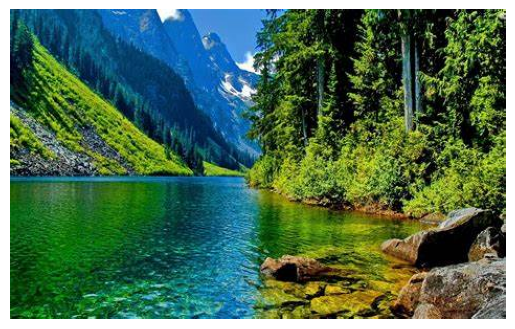

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread('OIP.jfif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")

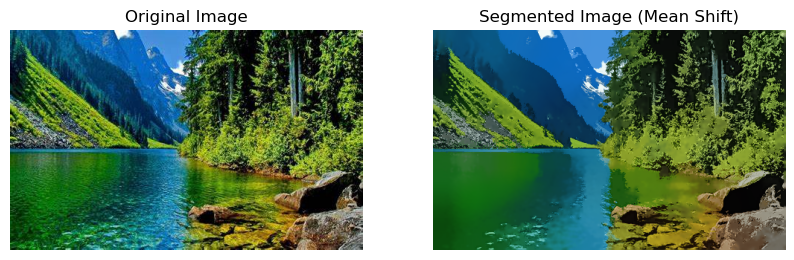

In [37]:
segmented_image = cv2.pyrMeanShiftFiltering(image, sp=20, sr=40)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image (Mean Shift)")
plt.axis("off")
plt.show()

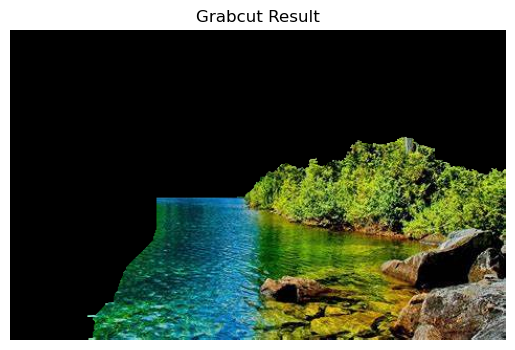

In [23]:
mask = np.zeros(image.shape[:2], np.uint8)

rect = (50, 50, 450, 290) 

bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
result = image * mask2[:, :, np.newaxis]

plt.imshow(result)
plt.title("Grabcut Result")
plt.axis("off")
plt.show()

In [24]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def kmeans_custom(image, k, max_iter=100):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    np.random.seed(42)
    centroids = pixel_values[np.random.choice(pixel_values.shape[0], k, replace=False)]
    
    for _ in range(max_iter):
        labels = np.array([np.argmin([euclidean_distance(pixel, centroid) for centroid in centroids]) for pixel in pixel_values])
        new_centroids = np.array([pixel_values[labels == i].mean(axis=0) if len(pixel_values[labels == i]) > 0 else centroids[i] for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return labels, centroids

(-0.5, 473.5, 295.5, -0.5)

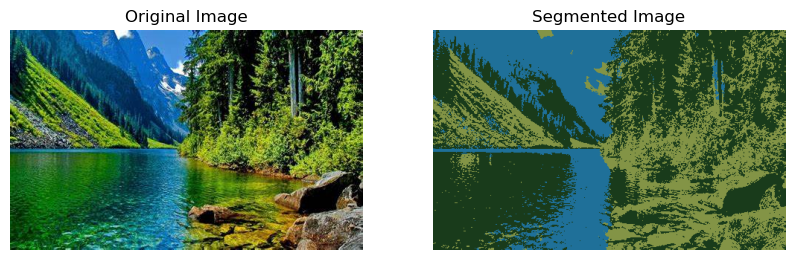

In [25]:
k = 3 
labels, centroids = kmeans_custom(image, k)
seg_image = centroids[labels].astype(np.uint8).reshape(image.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented Image")
plt.imshow(seg_image)
plt.axis('off')

In [26]:
def custom_threshold(image, threshold_value):
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    binary = np.zeros_like(gray)
    binary[gray > threshold_value] = 255
    return binary

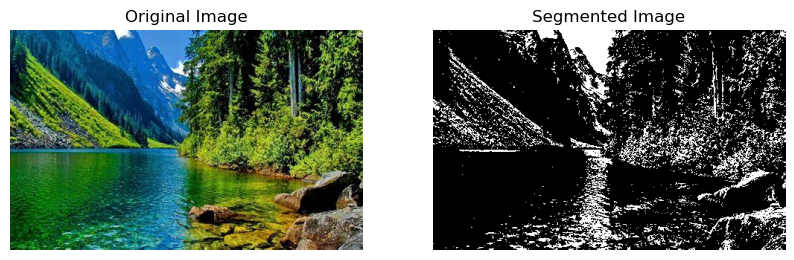

In [27]:
threshold_value = 128  
segmented_image = custom_threshold(image, threshold_value)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented Image")
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')

plt.show()

In [28]:
def region(image, seed, threshold):
    rows, cols = image.shape
    segmented_image = np.zeros_like(image)
    segmented_image[seed] = 255
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    to_process = [seed]
    while to_process:
        current_pixel = to_process.pop()
        x, y = current_pixel
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols:
                if segmented_image[nx, ny] == 0:
                    if abs(int(image[x, y]) - int(image[nx, ny])) <= threshold:
                        segmented_image[nx, ny] = 255
                        to_process.append((nx, ny))
    return segmented_image

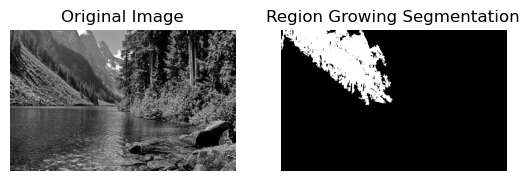

In [29]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
seed = (5, 5)
threshold = 10
segmented_image = region(image_gray, seed, threshold)
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('Region Growing Segmentation')
plt.axis("off")
plt.show()